General structure taken from Jon's A4 Notebook.

In [25]:
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy as sp
from scipy import stats, signal
import random
from sklearn import svm # needed for svm
from sklearn.metrics import confusion_matrix
import itertools
from scipy.io import wavfile
import librosa
from array import array

In [2]:
# Add preprocessing functions here if needed
def preprocess(rawSignal):
    
    # Add preprocessing functions here if needed
    return rawSignal

class SoundTrial:
    def __init__(self, soundName, trialNum, filenameWithPath):
        self.soundName = soundName
        self.trialNum = trialNum
        self.filenameWithPath = filenameWithPath
        self.filename = os.path.basename(filenameWithPath)
        
        sampleRate, data = wavfile.read(filenameWithPath)
    
        self.sound = data
        self.sound_float = data.astype(float)
        self.sound_p = preprocess(data)
        self.sample_rate = sampleRate
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.soundName, self.trialNum, self.filename)
      
    
    
class SoundSet:
    def __init__(self, sound_sample_path, map_sounds_to_trials):
        self.path = sound_sample_path
        self.map_sounds_to_trials = map_sounds_to_trials 
        
    # returns the base path
    def get_base_path(self):
        return os.path.basename(os.path.normpath(self.path))
    
    # returns the number of sounds
    def get_num_sounds(self):
        return len(self.map_sounds_to_trials)
    
    # returns the total number of trials
    def get_total_num_of_trials(self):
        numTrials = 0 
        for soundName, trialSet in self.map_sounds_to_trials.items():
            numTrials = numTrials + len(trialSet)
        return numTrials
    
    # returns a sorted list of gesture names
    def get_sound_names_sorted(self):
        return sorted(self.map_sounds_to_trials.keys())
    

    # THESE HAVEN'T BEEN CHANGED YET ****************************
    # returns the longest trial (based on num rows recorded and not clock time)
    def get_longest_trial(self):
        longest_trial_length = -1
        longest_trial = None
        for gesture_name, trial_list in self.map_gestures_to_trials.items():
            for trial in trial_list:
                if longest_trial_length < len(trial.accel.x):
                    longest_trial_length = len(trial.accel.x)
                    longest_trial = trial
        return longest_trial
    

    
    # returns trials for a gesture name
    def get_trials_for_gesture(self, gesture_name):
        return self.map_gestures_to_trials[gesture_name]
    
    # creates an aggregate signal based on *all* trials for this gesture
    # TODO: in future could add in an argument, which takes a list of trial nums
    # to use to produce aggregate signal
    def create_aggregate_signal(self, gesture_name, signal_var_name):
        trials = self.get_trials_for_gesture(gesture_name)
        aggregate_signal = None
        trial_signals = []
        trial_signals_original = []
        first_trial = None
        first_trial_signal = None
        
        max_length = -1
        for trial in trials:
            trial_signal = getattr(trial.accel, signal_var_name)
            if max_length < len(trial_signal):
                max_length = len(trial_signal)
            
        for i in range(len(trials)):
            if i == 0:
                first_trial = trials[i]
                trial_signal = getattr(first_trial.accel, signal_var_name)
                trial_signal_mod = np.copy(trial_signal)

                trial_signals.append(trial_signal_mod)
                trial_signals_original.append(trial_signal)
                
                array_length_diff = max_length - len(trial_signal_mod)
                trial_signal_mod = np.pad(trial_signal_mod, (0, array_length_diff), 'mean')  

                aggregate_signal = trial_signal_mod
                first_trial_signal = trial_signal_mod
            else:

                cur_trial = trials[i]
                cur_trial_signal = getattr(trial.accel, signal_var_name) 
                trial_signals_original.append(cur_trial_signal)
                
                array_length_diff = max_length - len(cur_trial_signal)
                cur_trial_signal_mod = np.pad(cur_trial_signal, (0, array_length_diff), 'mean') 

                cur_trial_signal_mod = get_aligned_signal_cutoff_and_pad(cur_trial_signal_mod, first_trial_signal)
                trial_signals.append(cur_trial_signal_mod)
                aggregate_signal += cur_trial_signal_mod
        
        mean_signal = aggregate_signal / len(trial_signals) 
        return mean_signal

    # Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
    # different number. We should have the same number of trials across all gestures)
    def get_min_num_of_trials(self):
        minNumTrials = -1 
        for gestureName, trialSet in self.map_gestures_to_trials.items():
            if minNumTrials == -1 or minNumTrials > len(trialSet):
                minNumTrials = len(trialSet)
        return minNumTrials
    
    # get random gesture name
    def get_random_gesture_name(self):
        gesture_names = list(self.map_gestures_to_trials.keys())
        rand_gesture_name = gesture_names[random.randint(0, len(gesture_names) - 1)]
        return rand_gesture_name
    
    # get random trial
    def get_random_trial(self):
        rand_gesture_name = self.get_random_gesture_name()
        print("rand_gesture_name", rand_gesture_name)
        trials_for_gesture = self.map_gestures_to_trials[rand_gesture_name]
        return trials_for_gesture[random.randint(0, len(trials_for_gesture) - 1)]
    
    
    
    # prettify the str()
    def __str__(self):
         return "'{}' : {} sounds and {} total trials".format(self.path, self.get_num_sounds(), self.get_total_num_of_trials())
        

In [3]:
from os import listdir
import ntpath
import os

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

# Currently excludes any filenames with 'fulldatastream' in the title
def find_wav_filenames( path_to_dir, suffix=".wav" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix )]

def parse_and_create_sound_trials( path_to_dir ):
    wavFilenames = find_wav_filenames(path_to_dir)
    
    print("Found {} wav files in {}".format(len(wavFilenames), path_to_dir))
    
    mapSoundNameToTrialList = dict()
    mapSoundNameToMapSampleNum = dict()
    for wavFilename in wavFilenames:
        
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(wavFilename)[0];
        filenameParts = filenameNoExt.split("_")
            
        soundName = filenameParts[0]
        sampleNum = filenameParts[1]
        fileName = "filename"
        #print("soundName={} sampleNum={}".format(soundName, sampleNum))
        
        
        if soundName not in mapSoundNameToMapSampleNum:
            mapSoundNameToMapSampleNum[soundName] = dict()
            
        if sampleNum not in mapSoundNameToMapSampleNum[soundName]:
            mapSoundNameToMapSampleNum[soundName][sampleNum] = dict()
            
        mapSoundNameToMapSampleNum[soundName][sampleNum][fileName] = wavFilename

        #print(mapSoundNameToMapSampleNum)
    
    print("Found {} sounds".format(len(mapSoundNameToMapSampleNum)))
   

    # Now we need to loop through the data and sort each sound set by timems values 
    # (so that we have trial 1, 2, 3, etc. in order)
    for soundName, mapSampleNumToFile in mapSoundNameToMapSampleNum.items():
        soundTrialNum = 0
        mapSoundNameToTrialList[soundName] = list()
        for sampleNum in sorted(mapSampleNumToFile.keys()):
            mapSampleToFile = mapSampleNumToFile[sampleNum]
            
            filenameWithPath = os.path.join(path_to_dir, mapSampleToFile["filename"])
            soundTrial = SoundTrial(soundName, soundTrialNum, filenameWithPath)
            mapSoundNameToTrialList[soundName].append(soundTrial)
            
            soundTrialNum = soundTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapSoundNameToTrialList[soundName]), soundName))

    return mapSoundNameToTrialList


In [17]:
# Load the data
root_sound_sample_path = './Samples'
target_dir_word = 'Kitchen'
print(get_immediate_subdirectories(root_sound_sample_path))
sound_sample_paths = get_immediate_subdirectories(root_sound_sample_path)

map_sound_sets = dict()
selected_sound_set = None

for sound_sample_path in sound_sample_paths:
    path_to_sound_sample = os.path.join(root_sound_sample_path, sound_sample_path)
    print("\nReading in:", path_to_sound_sample)
    map_sounds_to_trials = parse_and_create_sound_trials(path_to_sound_sample)
    sound_set = SoundSet(sound_sample_path, map_sounds_to_trials)
    map_sound_sets[sound_set.get_base_path()] = sound_set
    if target_dir_word in sound_sample_path:
            selected_sound_set = sound_set
    
if selected_sound_set is not None:
    print("\nThe selected sound set:", selected_sound_set)
    
def get_sound_set_with_str(str):
    for base_path, sound_set in map_sound_sets.items():
        if str in base_path:
            return sound_set
    return None

['6secSample', '6Test', 'Annie', 'ATest', 'Basic', 'MyKitchen', 'SMono', 'STest', 'Steven', 'thresholdStop']

Reading in: ./Samples\6secSample
Found 49 wav files in ./Samples\6secSample
Found 8 sounds
Found 6 trials for 'CoffeeGrinder'
Found 6 trials for 'FridgeDoorClose'
Found 6 trials for 'FridgeDoorOpen'
Found 6 trials for 'GarbageDisposal'
Found 6 trials for 'MicrowaveDoorClose'
Found 6 trials for 'MicrowaveDoorOpen'
Found 6 trials for 'MicrowaveEnding'
Found 7 trials for 'Toaster'

Reading in: ./Samples\6Test
Found 48 wav files in ./Samples\6Test
Found 8 sounds
Found 6 trials for 'CoffeeGrinder'
Found 6 trials for 'FridgeDoorClose'
Found 6 trials for 'FridgeDoorOpen'
Found 6 trials for 'GarbageDisposal'
Found 6 trials for 'MicrowaveDoorClose'
Found 6 trials for 'MicrowaveDoorOpen'
Found 6 trials for 'MicrowaveEnding'
Found 6 trials for 'Toaster'

Reading in: ./Samples\Annie
Found 37 wav files in ./Samples\Annie
Found 6 sounds
Found 7 trials for 'CoffeeGrinder'
Found 6 trials for '

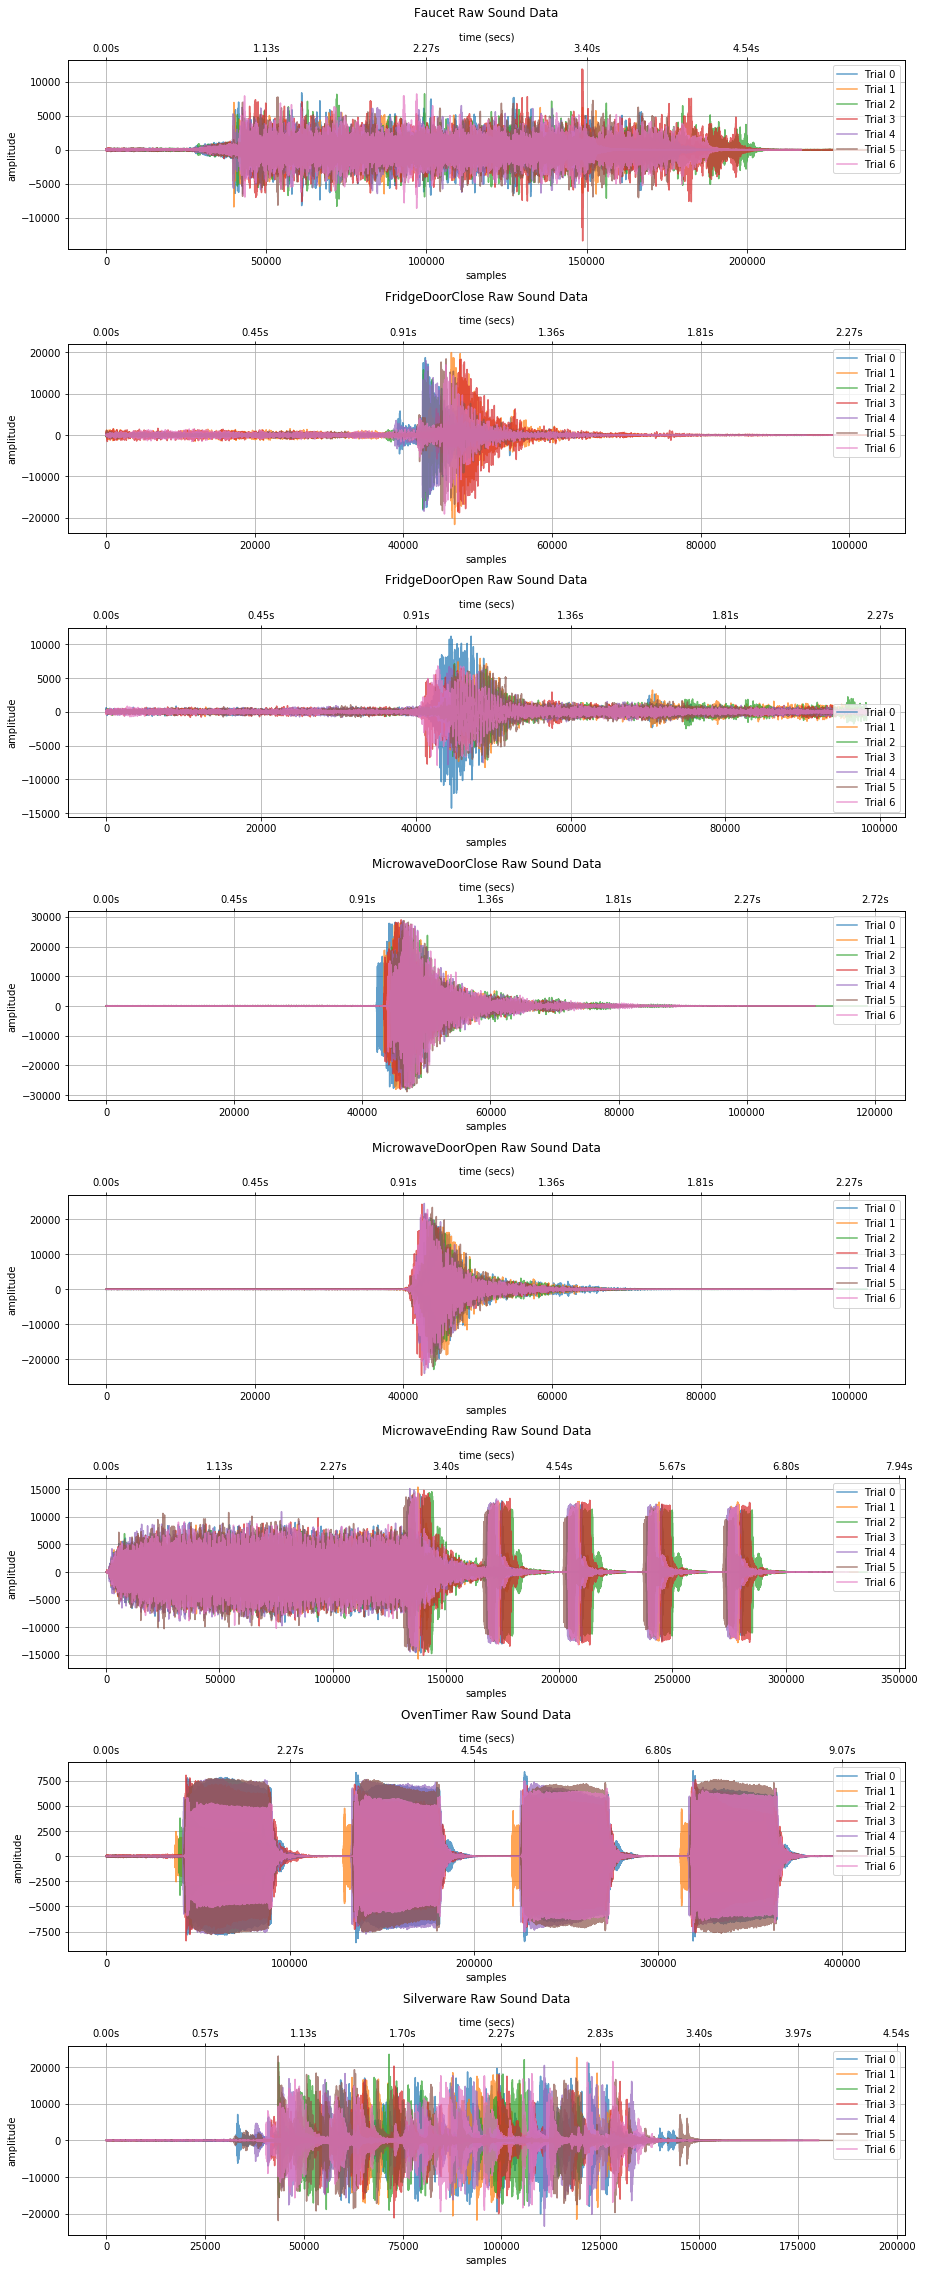

In [6]:
# Plotting adapted from A4 and PlayingWithSignals

map_sounds_to_trials = selected_sound_set.map_sounds_to_trials
fig, axes = plt.subplots(len(map_sounds_to_trials),1, figsize=(15, 5 * len(map_sounds_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
soundNamesSorted = sorted(map_sounds_to_trials.keys())
for soundName in soundNamesSorted:
    soundTrials = map_sounds_to_trials[soundName]
    trialNum = 0
    for trial in soundTrials:
        axes[index].plot(trial.sound, alpha=0.7, label="Trial {}".format(trialNum))
        sampleRate = trial.sample_rate
        trialNum = trialNum + 1
        
    axes[index].set_title(soundName + " Raw Sound Data", y=1.2)
    axes[index].legend()
    axes[index].grid()
    axes[index].set(xlabel="samples",ylabel="amplitude")
    
    ax2 = axes[index].twiny()
    ax2.set_xlim(axes[index].get_xlim())
    ax2.set_xlabel("time (secs)")
    ax_ticks = axes[index].get_xticks()[1:-1]
    ax2_tick_labels = axes[index].get_xticks()[1:-1] / sampleRate
    ax2_tick_labels = ['{:.2f}s'.format(x) for x in ax2_tick_labels]
    ax2.set_xticks(ax_ticks)
    ax2.set_xticklabels(ax2_tick_labels)
    
    index = index + 1
    

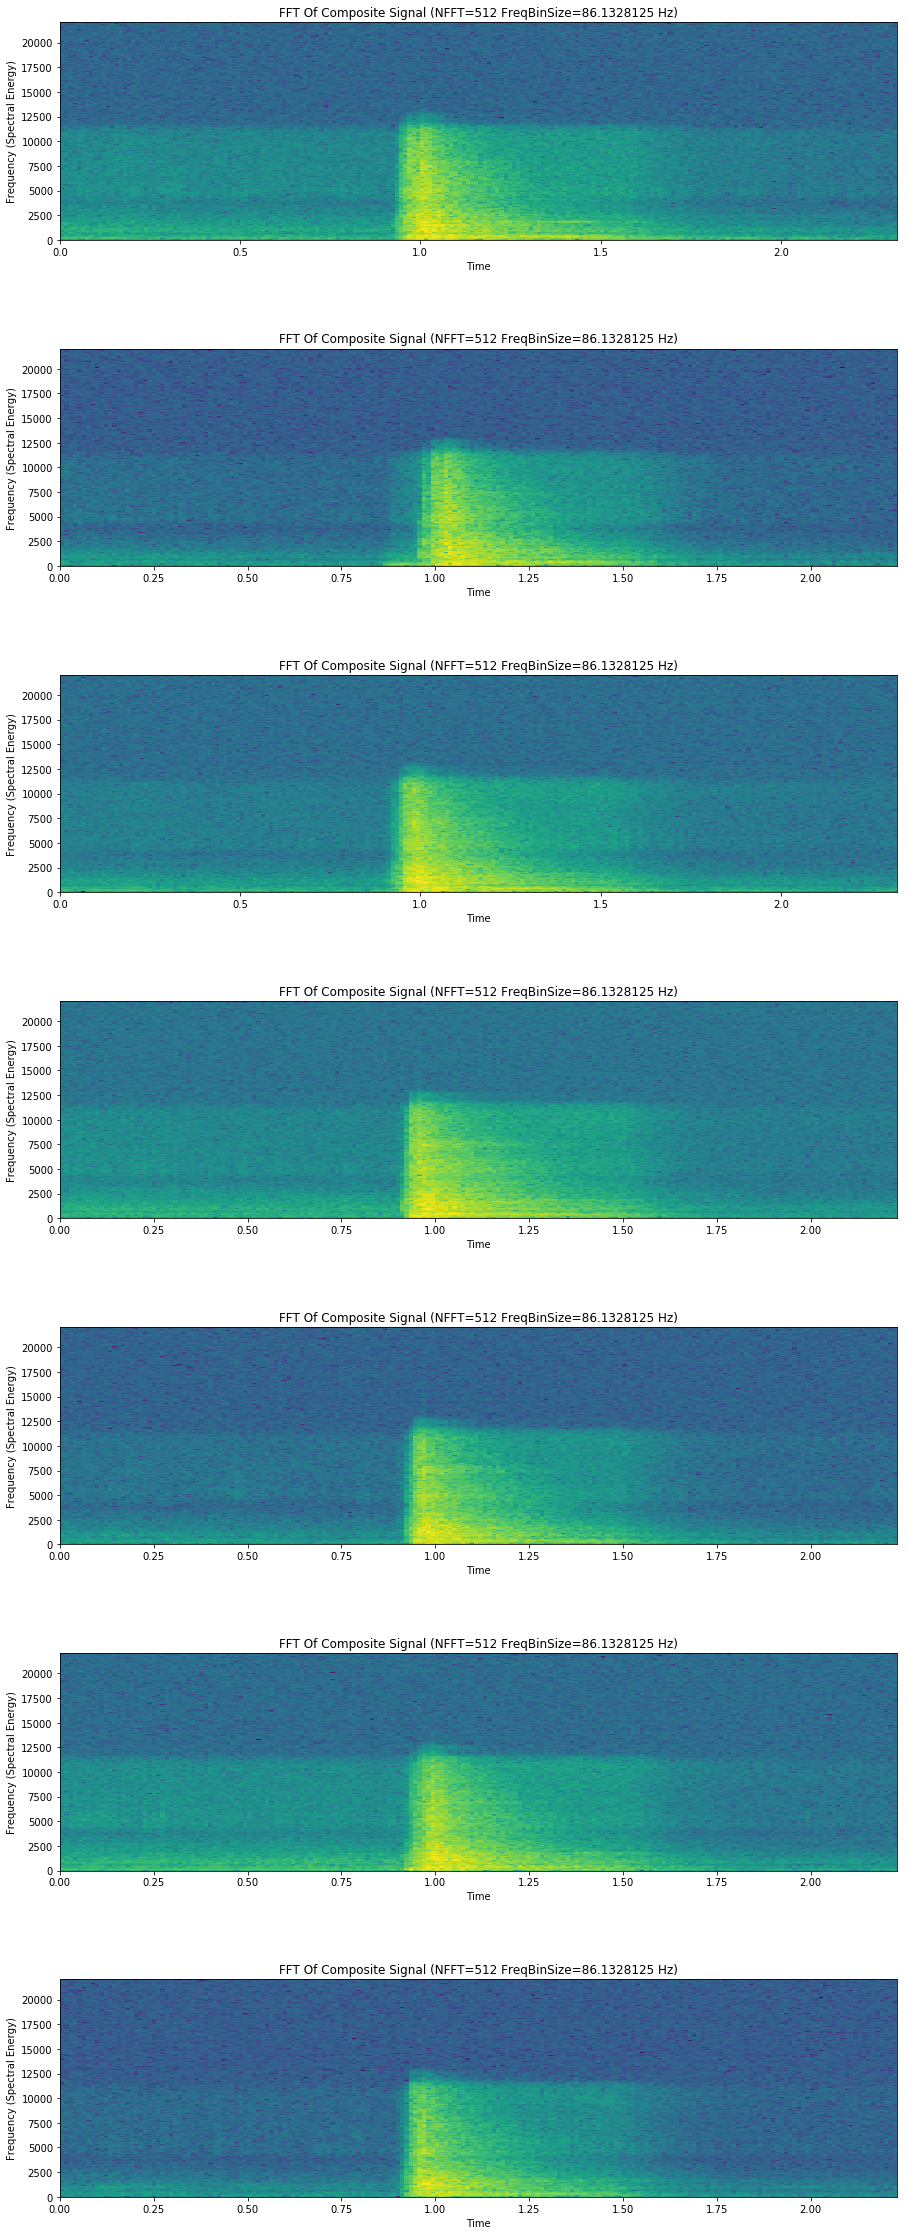

In [19]:
# Playing with FFT specgrams, adapted from PlayingWithSignals notebook

map_sounds_to_trials = selected_sound_set.map_sounds_to_trials
fig, axes = plt.subplots(len(map_sounds_to_trials)-1,1, figsize=(15, 5 * len(map_sounds_to_trials)))
fig.subplots_adjust(hspace=0.5)

index = 0
fft_window_size = 512
soundNamesSorted = sorted(map_sounds_to_trials.keys())
soundName = map_sounds_to_trials["MicrowaveDoorOpen"]
for trial in soundName:
    sample_rate = trial.sample_rate
    axes[index].specgram(trial.sound, NFFT=fft_window_size, Fs=sample_rate, noverlap=0)
    axes[index].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", 
            title='FFT Of Composite Signal (NFFT={} FreqBinSize={} Hz)'.
            format(fft_window_size, sample_rate/fft_window_size))
    
    index = index + 1

In [8]:
from sklearn import svm # needed for svm
from sklearn.metrics import confusion_matrix
import itertools

# Returns a list of folds where each list item is a dict() with key=sound name and value=selected trial 
# for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
# setting up experiments)
def generate_kfolds(numFolds, map_sounds_to_trials, seed=None):
    
    # Quick check to make sure that there are numFolds of sound trials for each sound
    for soundName, trials in map_sounds_to_trials.items():
        if numFolds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each sound. Sound '{}' has {} trials"
                             .format(numFolds, soundName, len(trials)))


    numSounds = len(map_sounds_to_trials)
    tmpMapSoundToTrials = dict()
    for soundName, trials in map_sounds_to_trials.items():
        tmpMapSoundToTrials[soundName] = list(trials)
    
    soundNames = list(map_sounds_to_trials.keys())

    # create folds
    foldToMapSoundToTrial = list()
    random.seed(seed)
    for i in range(0, numFolds):
        curFoldMapSoundToTrial = dict()
        foldToMapSoundToTrial.append(curFoldMapSoundToTrial)
        
        for j in range(0, numSounds):
            curSoundName = soundNames[j]
            trialList = tmpMapSoundToTrials[curSoundName]
            randTrialIndex = 0
            if (len(trialList) > 0):
                randTrialIndex = random.randint(0, len(trialList) - 1)

            randTrial = trialList[randTrialIndex]
            curFoldMapSoundToTrial[curSoundName] = randTrial
            del trialList[randTrialIndex]
    
    return foldToMapSoundToTrial

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
# Feature extraction testing
# https://musicinformationretrieval.com/genre_recognition.html

import sklearn
import numpy

n_mfcc = 12
scaler = sklearn.preprocessing.StandardScaler()

def get_mfcc (trial):
    s = trial.sound_float
    r = trial.sample_rate
    
    mfcc = librosa.feature.mfcc(s, sr=r, n_mfcc=n_mfcc).T
    mfcc_scaled = scaler.fit_transform(mfcc)
    
    return mfcc

targeted_string = "ATest"
selected_sound_set = get_sound_set_with_str(targeted_string)
sound_trials = selected_sound_set.map_sounds_to_trials


soundName = sound_trials["CoffeeGrinder"]
features = np.empty((0,12))
for trial in soundName:
    extract_features(trial)
    
    print(features.shape)


(0, 12)
(0, 12)
(0, 12)
(0, 12)
(0, 12)


Learning how to add multi-dimensional features


Starting fold #1
Got features from CoffeeGrinder #0...
Got features from FridgeDoorClose #1...
Got features from FridgeDoorOpen #0...
Got features from GarbageDisposal #2...
Got features from MicrowaveDoorClose #4...
Got features from MicrowaveDoorOpen #1...
Got features from MicrowaveEnding #4...

Starting fold #2
Got features from CoffeeGrinder #3...
Got features from FridgeDoorClose #0...
Got features from FridgeDoorOpen #4...
Got features from GarbageDisposal #0...
Got features from MicrowaveDoorClose #1...
Got features from MicrowaveDoorOpen #4...
Got features from MicrowaveEnding #0...

Starting fold #3
Got features from CoffeeGrinder #2...
Got features from FridgeDoorClose #4...
Got features from FridgeDoorOpen #1...
Got features from GarbageDisposal #3...
Got features from MicrowaveDoorClose #2...
Got features from MicrowaveDoorOpen #0...
Got features from MicrowaveEnding #2...

Starting fold #4
Got features from CoffeeGrinder #1...
Got features from FridgeDoorClose #3...
Got 

C:\Users\Steven\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CoffeeGrinder!

I predict FridgeDoorClose is...  
FridgeDoorClose!

I predict FridgeDoorOpen is...  
FridgeDoorOpen!

I predict GarbageDisposal is...  
GarbageDisposal!

I predict MicrowaveDoorClose is...  
MicrowaveDoorClose!

I predict MicrowaveDoorOpen is...  
MicrowaveDoorOpen!

I predict MicrowaveEnding is...  
MicrowaveEnding!

Starting fold #1
Got features from CoffeeGrinder #4...
Got features from FridgeDoorClose #2...
Got features from FridgeDoorOpen #2...
Got features from GarbageDisposal #4...
Got features from MicrowaveDoorClose #0...
Got features from MicrowaveDoorOpen #3...
Got features from MicrowaveEnding #1...

Starting fold #2
Got features from CoffeeGrinder #3...
Got features from FridgeDoorClose #0...
Got features from FridgeDoorOpen #4...
Got features from GarbageDisposal #0...
Got features from MicrowaveDoorClose #1...
Got features from MicrowaveDoorOpen #4...
Got features from MicrowaveEnding #0...

Starting fold #3
Got features from CoffeeGrinder #2...
Got featu

C:\Users\Steven\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CoffeeGrinder!

I predict FridgeDoorClose is...  
FridgeDoorClose!

I predict FridgeDoorOpen is...  
FridgeDoorOpen!

I predict GarbageDisposal is...  
GarbageDisposal!

I predict MicrowaveDoorClose is...  
MicrowaveDoorClose!

I predict MicrowaveDoorOpen is...  
MicrowaveDoorOpen!

I predict MicrowaveEnding is...  
MicrowaveEnding!

Starting fold #1
Got features from CoffeeGrinder #4...
Got features from FridgeDoorClose #2...
Got features from FridgeDoorOpen #2...
Got features from GarbageDisposal #4...
Got features from MicrowaveDoorClose #0...
Got features from MicrowaveDoorOpen #3...
Got features from MicrowaveEnding #1...

Starting fold #2
Got features from CoffeeGrinder #0...
Got features from FridgeDoorClose #1...
Got features from FridgeDoorOpen #0...
Got features from GarbageDisposal #2...
Got features from MicrowaveDoorClose #4...
Got features from MicrowaveDoorOpen #1...
Got features from MicrowaveEnding #4...

Starting fold #3
Got features from CoffeeGrinder #2...
Got featu

C:\Users\Steven\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CoffeeGrinder!

I predict FridgeDoorClose is...  
FridgeDoorClose!

I predict FridgeDoorOpen is...  
FridgeDoorOpen!

I predict GarbageDisposal is...  
GarbageDisposal!

I predict MicrowaveDoorClose is...  
MicrowaveDoorClose!

I predict MicrowaveDoorOpen is...  
MicrowaveDoorOpen!

I predict MicrowaveEnding is...  
MicrowaveEnding!

Starting fold #1
Got features from CoffeeGrinder #4...
Got features from FridgeDoorClose #2...
Got features from FridgeDoorOpen #2...
Got features from GarbageDisposal #4...
Got features from MicrowaveDoorClose #0...
Got features from MicrowaveDoorOpen #3...
Got features from MicrowaveEnding #1...

Starting fold #2
Got features from CoffeeGrinder #0...
Got features from FridgeDoorClose #1...
Got features from FridgeDoorOpen #0...
Got features from GarbageDisposal #2...
Got features from MicrowaveDoorClose #4...
Got features from MicrowaveDoorOpen #1...
Got features from MicrowaveEnding #4...

Starting fold #3
Got features from CoffeeGrinder #3...
Got featu

C:\Users\Steven\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CoffeeGrinder!

I predict FridgeDoorClose is...  
FridgeDoorClose!

I predict FridgeDoorOpen is...  
FridgeDoorOpen!

I predict GarbageDisposal is...  
GarbageDisposal!

I predict MicrowaveDoorClose is...  
MicrowaveDoorClose!

I predict MicrowaveDoorOpen is...  
MicrowaveDoorClose!

I predict MicrowaveEnding is...  
MicrowaveEnding!

Starting fold #1
Got features from CoffeeGrinder #4...
Got features from FridgeDoorClose #2...
Got features from FridgeDoorOpen #2...
Got features from GarbageDisposal #4...
Got features from MicrowaveDoorClose #0...
Got features from MicrowaveDoorOpen #3...
Got features from MicrowaveEnding #1...

Starting fold #2
Got features from CoffeeGrinder #0...
Got features from FridgeDoorClose #1...
Got features from FridgeDoorOpen #0...
Got features from GarbageDisposal #2...
Got features from MicrowaveDoorClose #4...
Got features from MicrowaveDoorOpen #1...
Got features from MicrowaveEnding #4...

Starting fold #3
Got features from CoffeeGrinder #3...
Got feat

C:\Users\Steven\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CoffeeGrinder!

I predict FridgeDoorClose is...  
FridgeDoorClose!

I predict FridgeDoorOpen is...  
FridgeDoorOpen!

I predict GarbageDisposal is...  
GarbageDisposal!

I predict MicrowaveDoorClose is...  
MicrowaveDoorClose!

I predict MicrowaveDoorOpen is...  
MicrowaveDoorOpen!

I predict MicrowaveEnding is...  
MicrowaveEnding!
SVM Results on "ATest" Dataset:

CoffeeGrinder: 5/5 (100.0%)
FridgeDoorClose: 5/5 (100.0%)
FridgeDoorOpen: 5/5 (100.0%)
GarbageDisposal: 5/5 (100.0%)
MicrowaveDoorClose: 5/5 (100.0%)
MicrowaveDoorOpen: 4/5 (80.0%)
MicrowaveEnding: 5/5 (100.0%)

Total SVM classifier accuracy 97.14%



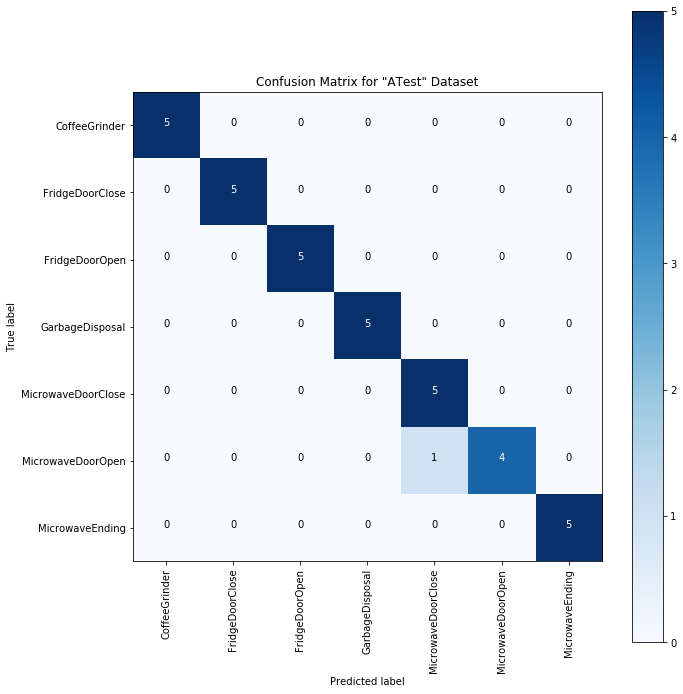

Wall time: 32.2 s


In [34]:
%%time

# This is the simplest possible SVM using only a few features but gives you a sense of the overall approach
# Some nice resources:
#  - A very simple classification example using scikit: 
#     https://dbaumgartel.wordpress.com/2014/03/10/a-scikit-learn-example-in-10-lines/
#  - A nice video overview of SVM: https://youtu.be/N1vOgolbjSc
#  - Official sci-kit learn: http://scikit-learn.org/stable/modules/svm.html

from sklearn import svm
from sklearn.preprocessing import StandardScaler
import itertools
from scipy.stats import kurtosis, skew

def predict(sound, rate):
    features = universal_features
    prediction = clf.predict([features])
    print(prediction)
    return prediction

def extract_features(trial):
    s = trial.sound_float
    r = trial.sample_rate
    
    features = universal_features(s, r)
    
    return features

# Returns a feature vectof for the given trial
def universal_features(s, r):
    
    stft = np.abs(librosa.stft(s))

    mfcc =  np.mean(librosa.feature.mfcc(y=s, sr=r, n_mfcc=50).T,axis=0)
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=r).T,axis=0)
    
    # This make everything seem like "Toaster"
    mel = np.mean(librosa.feature.melspectrogram(s, r).T,axis=0)
    
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=r).T,axis=0)

    # This adds some accuracy but takes forever
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(s), sr=r).T,axis=0)
    
    zero_x = np.mean(librosa.feature.zero_crossing_rate(s).T,axis=0)
    

    
    features = np.hstack([mfcc, chroma, contrast, zero_x])
    
    
    
    #print(features.shape)
    return(features)

targeted_string = "ATest"
numFolds = 5
selected_sound_set = get_sound_set_with_str(targeted_string)
numSounds = selected_sound_set.get_num_sounds()
numTrialsTotal = selected_sound_set.get_total_num_of_trials()

# Setting a seed here keeps producing the same folds set each time. Take that out
# if you want to randomly produce a fold set on every execution
foldToMapSoundToTrial = generate_kfolds(numFolds, selected_sound_set.map_sounds_to_trials, seed=5)
mapSoundToCorrectMatches = dict()

y_true = []
y_pred = []

soundNamesSorted = selected_sound_set.get_sound_names_sorted()
for soundName in soundNamesSorted:
    mapSoundToCorrectMatches[soundName] = 0

for i in range(0, len(foldToMapSoundToTrial)):
    trainingFolds = foldToMapSoundToTrial.copy()
    testFold = trainingFolds.pop(i)
    
    trainingData = np.empty((0,70))
    classLabels = np.empty(0)
    
    # build training data for this set of folds
    foldNum = 1
    for trainingFold in trainingFolds:
        print("\nStarting fold #{}".format(foldNum))
        for trainingSoundName, trainingTrial in trainingFold.items():
            features = extract_features(trainingTrial)
            print("Got features from {} #{}...".format(trainingSoundName, trainingTrial.trialNum))
            #print(features.shape)
            trainingData = np.vstack([trainingData,features])
            classLabels = np.append(classLabels, trainingSoundName)
            
        foldNum = foldNum + 1
            
    print("\n\n\nFitting data...\n")

    # Here, we train SVM, the 'rbf' kernal is default
    # if you use rbf, need to set gamma and C parameters
    # play around with different kernels, read about them, and try them. What happens?
    # see: 
    # - https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
    # - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    clf = svm.LinearSVC() # kernel='rbf'
    clf.fit(trainingData, classLabels) 
    
    # make predictions for this test set
    for testSoundName, testTrial in testFold.items():
        print("\nI predict {} is...  ".format(testSoundName))
        features = extract_features(testTrial)
        svmPrediction = clf.predict([features])
        
        print("{}!".format(svmPrediction[0]))
        y_true.append(testSoundName)
        y_pred.append(svmPrediction)
        
        if testSoundName == svmPrediction[0]:
            mapSoundToCorrectMatches[testSoundName] += 1
                
totalCorrectMatches = 0
print("SVM Results on \"{}\" Dataset:\n".format(targeted_string))
for sound in mapSoundToCorrectMatches:
    c = mapSoundToCorrectMatches[sound]
    print("{}: {}/{} ({}%)".format(sound, c, numFolds, c / numFolds * 100))
    totalCorrectMatches += mapSoundToCorrectMatches[sound]
    
print("\nTotal SVM classifier accuracy {:0.2f}%\n".format(totalCorrectMatches / numTrialsTotal * 100))

cm = confusion_matrix(y_true, y_pred, soundNamesSorted)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=soundNamesSorted, title='Confusion Matrix for \"{}\" Dataset'.format(targeted_string))
plt.show()